<a href="https://colab.research.google.com/github/alirezash97/BRATS2015/blob/master/results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:

import os
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import cv2
import keras 
import random

In [1]:
from keras import backend as K

def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):
  
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true**2, axis=axis) + K.sum(y_pred**2, axis=axis) + epsilon
    dice_loss = 1 - K.mean((dice_numerator)/(dice_denominator))


    return dice_loss


def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), 
                     epsilon=0.00001):

    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis) + epsilon
    dice_coefficient = K.mean((dice_numerator)/(dice_denominator))
    
 
    return dice_coefficient

Using TensorFlow backend.


In [2]:

# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
 
# load model
model = load_model('/content/drive/My Drive/BRATS2020/FlowerModel.01-0.39.h5', custom_objects={'soft_dice_loss':soft_dice_loss, 'dice_coefficient':dice_coefficient})
# summarize model.
model.summary()
# load dataset

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 80, 80, 16, 4 0                                            
__________________________________________________________________________________________________
conv3d_58 (Conv3D)              (None, 80, 80, 16, 3 3488        input_2[0][0]                    
__________________________________________________________________________________________________
conv3d_72 (Conv3D)              (None, 80, 80, 16, 3 3488        input_2[0][0]                    
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 80, 80, 16, 3 0           conv3d_58[0][0]                  
____________________________________________________________________________________________

In [5]:
import glob, os
images_path = glob.glob('/content/drive/My Drive/BRATS2020/MICCAI_BraTS2020_TrainingData/**/*.nii.gz', recursive=True)

data_path = ""

X_trainset_filenames = []
y_trainset_filenames = []

for item in images_path:
  if 'seg' in item:
    y_trainset_filenames.append(os.path.join(data_path, item))
  else:
    X_trainset_filenames.append(os.path.join(data_path, item))

In [6]:
def load_case(image_nifty_file, label_nifty_file):
    
    # load the image and label file, get the image content and return a numpy array for each
    image = np.zeros((240, 240, 155, 4))

    img0 = np.array(nib.load(image_nifty_file[0]).get_fdata())
    img1 = np.array(nib.load(image_nifty_file[1]).get_fdata())
    img2 = np.array(nib.load(image_nifty_file[2]).get_fdata())
    img3 = np.array(nib.load(image_nifty_file[3]).get_fdata())
    
    image[:, :, :, 0] = img0
    image[:, :, :, 1] = img1
    image[:, :, :, 2] = img2
    image[:, :, :, 3] = img3
      
    label = np.array(nib.load(label_nifty_file).get_fdata())
    
    
    return image, label

In [74]:
image , label = load_case(X_trainset_filenames[26:30], y_trainset_filenames[6])

In [12]:
def get_sub_volume(image, label, 
                   orig_x = 240, orig_y = 240, orig_z = 155, 
                   output_x = 80, output_y = 80, output_z = 16,
                   num_classes = 4, max_tries = 1000, 
                   background_threshold=0.95):
  

    ############## voxel categories were 0, 1, 2, 4 

    for i in range(240):
      for j in range(240):
        for k in range(155):
          if label[i, j, k] == 4.0 :
            label[i, j, k] = 3.0
          else:
            pass


    ########## voxel categpries are 0, 1, 2, 3 for better categorization 

    
    # Initialize features and labels with `None`

    
    tries = 0
    
    while tries < max_tries:
        # randomly sample sub-volume by sampling the corner voxel
        # hint: make sure to leave enough room for the output dimensions!
        start_x = np.random.randint(0, (orig_x - output_x + 1))
        start_y = np.random.randint(0, (orig_y - output_y + 1))
        start_z = np.random.randint(0, (orig_z - output_z + 1))

        # extract relevant area of label
        y = label[start_x: start_x + output_x,
                  start_y: start_y + output_y,
                  start_z: start_z + output_z]
        
        # One-hot encode the categories.
        # This adds a 4th dimension, 'num_classes'
        # (output_x, output_y, output_z, num_classes)
        y = keras.utils.to_categorical(y, num_classes=num_classes)

        # compute the background ratio
        bgrd_ratio = np.sum(y[:, :, :, 0]) / (output_x * output_y * output_z)

        # increment tries counter
        tries += 1

        # if background ratio is below the desired threshold,
        # use that sub-volume.
        # otherwise continue the loop and try another random sub-volume
        if bgrd_ratio < background_threshold:

            # make copy of the sub-volume
            X = np.copy(image[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              start_z: start_z + output_z, :])
            
            # change dimension of X
            # from (x_dim, y_dim, z_dim, num_channels)
            # to (num_channels, x_dim, y_dim, z_dim)
            X = np.moveaxis(X, 3, 0)

            # change dimension of y
            # from (x_dim, y_dim, z_dim, num_classes)
            # to (num_classes, x_dim, y_dim, z_dim)
            y = np.moveaxis(y, 3, 0)
            
            # take a subset of y that excludes the background class
            # in the 'num_classes' dimension
            y = y[1:, :, :, :]
    
            return X, y

In [75]:
X, y = get_sub_volume(image, label)

In [14]:
def visualize_patch(X, y):
    fig, ax = plt.subplots(1, 2, figsize=[10, 5], squeeze=False)

    ax[0][0].imshow(X[:, :, 0], cmap='Greys_r')
    ax[0][0].set_yticks([])
    ax[0][0].set_xticks([])
    ax[0][1].imshow(y[:, :, 0], cmap='Greys_r')
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])

    fig.subplots_adjust(wspace=0, hspace=0)

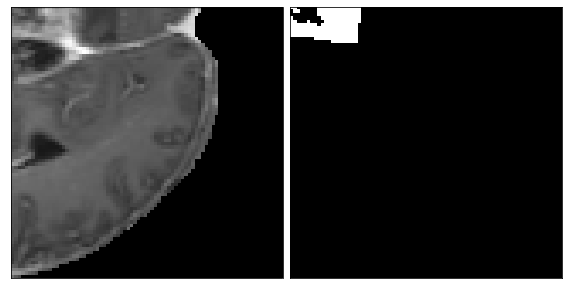

In [76]:
visualize_patch(X[1, :, :, :], y[2])

In [77]:
X_X = np.moveaxis(X, 3, 0)
X_X = X_X.reshape((1, 80, 80, 16, 4))

y_pred = model.predict(X_X)

In [22]:
y_pred.shape

(1, 80, 80, 16, 3)

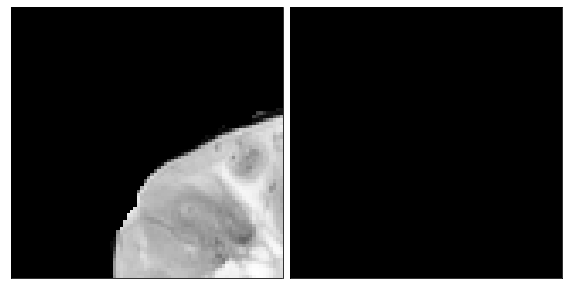

In [70]:
visualize_patch(X[1, :, :, :], y_pred[0, :, :, :, 2])

In [ ]:
from ipywidgets import interact

def explore_3dimage(layer):
    plt.figure(figsize=(10, 5))
    channel = 3
    plt.imshow(img[:, :, layer], cmap='gray');
    plt.title('Explore Layers of Brain MRI', fontsize=20)
    plt.axis('off')
    return layer

# Run the ipywidgets interact() function to explore the data
interact(explore_3dimage, layer=(0, 155 - 1));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

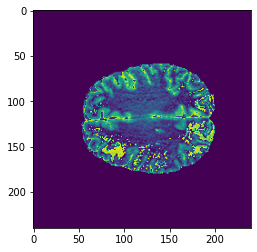

In [ ]:
plt.imshow((img[0, :, :, 100] * 255).astype(np.uint8))

In [ ]:
print(y_predict.shape)

(1, 240, 240, 155)


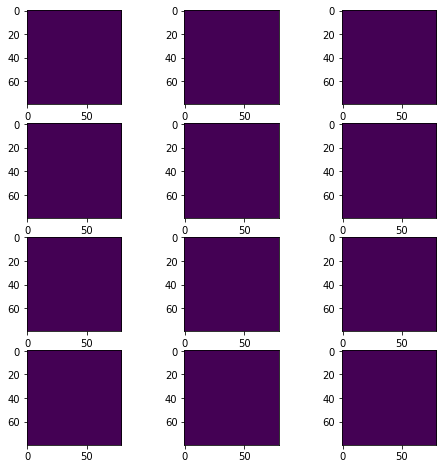

In [78]:
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 4
for i in range(1, columns*rows +1):
    img = y_pred[0, :, :, i, 2]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

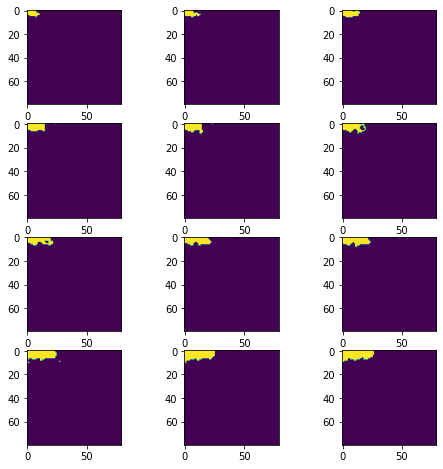

In [79]:
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 4
for i in range(1, columns*rows +1):
    img = y[0, :, :, i]
    fig.add_subplot(rows, columns, i)
    plt.imshow((img * 255).astype(np.uint8))
plt.show()